# Data Analysis on Experiments Dataset

In [1]:
import pandas as pd
import os
from pathlib import Path

In [6]:
experiment_names = ['exp_20260113_181118']

In [7]:
def load_experiment_data(exp_name):

    exp_path = Path(exp_name)
    
    xlsx_file = exp_path / 'merged_results.xlsx'
    csv_file = exp_path / 'merged_results.csv'
    
    if xlsx_file.exists():
        df = pd.read_excel(xlsx_file)
        file_type = 'xlsx'
    elif csv_file.exists():
        df = pd.read_csv(csv_file)
        file_type = 'csv'
    else:
        raise FileNotFoundError(f"No merged_results file found in {exp_name}")
    
    if 'best_classic_objective' in df.columns:
        exp_type = 'optimization'
    elif 'clifford_ideal_estimation_time' in df.columns:
        exp_type = 'performance'
    else:
        raise ValueError(f"Cannot determine experiment type for {exp_name}. Missing expected columns.")
    
    print(f"Loaded {exp_name}: {len(df)} rows, type={exp_type}, format={file_type}")
    
    return df, exp_type

In [8]:
df, exp_type = load_experiment_data(experiment_names[0])
df['experiment_name'] = experiment_names[0]

print(f"\nExpected experiment type: {exp_type}")
print(f"Initialized with {len(df)} rows from {experiment_names[0]}")

Loaded exp_20260113_181118: 53 rows, type=performance, format=xlsx

Expected experiment type: performance
Initialized with 53 rows from exp_20260113_181118


In [9]:
all_consistent = True

for exp_name in experiment_names[1:]:
    current_df, current_exp_type = load_experiment_data(exp_name)
    
    if current_exp_type != exp_type:
        print(f"\nERROR: Experiment {exp_name} has type '{current_exp_type}', expected '{exp_type}'")
        print(f"✗ Stopping merge process due to inconsistent types.")
        all_consistent = False
        break
    else:
        # Add experiment name column and merge immediately
        current_df['experiment_name'] = exp_name
        df = pd.concat([df, current_df], ignore_index=True)
        print(f"Merged {exp_name}: Total rows now = {len(df)}")
    print(f"\nFirst few rows:")
if all_consistent:
    print(f"\n✓ All {len(experiment_names)} experiments merged successfully!")
    print(f"Total rows: {len(df)}")
    print(f"Total columns: {len(df.columns)}\n")
    display(df.head())
else:
    print(f"\nMerge incomplete. Current dataframe contains {len(df)} rows.")


✓ All 1 experiments merged successfully!
Total rows: 53
Total columns: 46



,label,seed,problem_class,circuit_class,backend,logic_qubits,backend_qubits,layers,num_estimator_shots,ideal_energy,...,transpiled_qc_metrics.total_gates,transpiled_qc_metrics.num_active_qubits,clifford_qc_metrics.depth,clifford_qc_metrics.2q_gates,clifford_qc_metrics.clifford_gates,clifford_qc_metrics.non_clifford_gates,clifford_qc_metrics.t_gates,clifford_qc_metrics.total_gates,clifford_qc_metrics.num_active_qubits,experiment_name
0,N_nodes12_N_layers1_out,12345,MaxCutProblem,QAOACircuit,ibm_torino,12,133,1,10000,NaN,...,1908,12,323,90,90,791,0,881,12,exp_20260113_181118
1,N_nodes12_N_layers2_out,12345,MaxCutProblem,QAOACircuit,ibm_torino,12,133,2,10000,NaN,...,4447,12,973,364,364,2828,0,3192,12,exp_20260113_181118
2,N_nodes12_N_layers3_out,12345,MaxCutProblem,QAOACircuit,ibm_torino,12,133,3,10000,NaN,...,6956,15,1388,503,503,4115,0,4618,15,exp_20260113_181118
3,N_nodes12_N_layers4_out,12345,MaxCutProblem,QAOACircuit,ibm_torino,12,133,4,10000,NaN,...,8905,12,1902,577,577,4894,0,5471,12,exp_20260113_181118
4,N_nodes12_N_layers5_out,12345,MaxCutProblem,QAOACircuit,ibm_torino,12,133,5,10000,NaN,...,11475,12,2627,863,863,7109,0,7972,12,exp_20260113_181118


## Performance Analysis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if exp_type == 'performance':
    print(f"Performance experiments: {df['experiment_name'].unique()}")
    print(f"Total performance records: {len(df)}")
else:
    print("Current dataset contains optimization experiments, not performance.")

Performance experiments: ['exp_20260113_181118']
Total performance records: 53


In [ ]:
def plot_clifford_estimation_times_vs(x_var, df):
    """
    Plot clifford estimation times against a given x variable.

    Parameters:
    x_var (str): Column name for x-axis
    df (pd.DataFrame): Dataframe containing the data
    """
    if exp_type != 'performance':
        print("Not a performance dataset")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    x_vals = df[x_var].values

    ax.scatter(df[x_var], df['clifford_ideal_estimation_time'], marker='o', label='Ideal', alpha=0.5, s=50)
    color_ideal = ax.collections[-1].get_facecolors()[0]

    ax.scatter(df[x_var], df['clifford_noisy_estimation_time'], marker='s', label='Noisy', alpha=0.5, s=50)
    color_noisy = ax.collections[-1].get_facecolors()[0]

    ax.scatter(df[x_var], df['clifford_pruned_estimation_time'], marker='^', label='Pruned', alpha=0.5, s=50)
    color_pruned = ax.collections[-1].get_facecolors()[0]

    x_smooth = np.linspace(x_vals.min(), x_vals.max(), 300)

    z_ideal = np.polyfit(x_vals, df['clifford_ideal_estimation_time'], 2)
    p_ideal = np.poly1d(z_ideal)
    ax.plot(x_smooth, p_ideal(x_smooth), color=color_ideal, linewidth=3, alpha=1.0)

    z_noisy = np.polyfit(x_vals, df['clifford_noisy_estimation_time'], 2)
    p_noisy = np.poly1d(z_noisy)
    ax.plot(x_smooth, p_noisy(x_smooth), color=color_noisy, linewidth=3, alpha=1.0)

    z_pruned = np.polyfit(x_vals, df['clifford_pruned_estimation_time'], 2)
    p_pruned = np.poly1d(z_pruned)
    ax.plot(x_smooth, p_pruned(x_smooth), color=color_pruned, linewidth=3, alpha=1.0)

    ax.set_xlabel(x_var, fontsize=12)
    ax.set_ylabel('Estimation Time', fontsize=12)
    ax.set_title(f'Clifford Estimation Time vs {x_var}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_depths_vs(x_var, df):
    """
    Plot depth metrics against a given x variable.

    Parameters:
    x_var (str): Column name for x-axis
    df (pd.DataFrame): Dataframe containing the data
    """
    if exp_type != 'performance':
        print("Not a performance dataset")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    x_vals = df[x_var].values

    ax.scatter(df[x_var], df['virtual_qc_metrics.depth'], marker='o', label='Virtual depth', alpha=0.5, s=50)
    color_virtual = ax.collections[-1].get_facecolors()[0]

    ax.scatter(df[x_var], df['transpiled_qc_metrics.depth'], marker='s', label='Transpiled depth', alpha=0.5, s=50)
    color_transpiled = ax.collections[-1].get_facecolors()[0]

    ax.scatter(df[x_var], df['clifford_qc_metrics.depth'], marker='^', label='Clifford depth', alpha=0.5, s=50)
    color_clifford = ax.collections[-1].get_facecolors()[0]

    x_smooth = np.linspace(x_vals.min(), x_vals.max(), 300)

    z_virtual = np.polyfit(x_vals, df['virtual_qc_metrics.depth'], 2)
    p_virtual = np.poly1d(z_virtual)
    ax.plot(x_smooth, p_virtual(x_smooth), color=color_virtual, linewidth=3, alpha=1.0)

    z_transpiled = np.polyfit(x_vals, df['transpiled_qc_metrics.depth'], 2)
    p_transpiled = np.poly1d(z_transpiled)
    ax.plot(x_smooth, p_transpiled(x_smooth), color=color_transpiled, linewidth=3, alpha=1.0)

    z_clifford = np.polyfit(x_vals, df['clifford_qc_metrics.depth'], 2)
    p_clifford = np.poly1d(z_clifford)
    ax.plot(x_smooth, p_clifford(x_smooth), color=color_clifford, linewidth=3, alpha=1.0)

    ax.set_xlabel(x_var, fontsize=12)
    ax.set_ylabel('Circuit Depth', fontsize=12)
    ax.set_title(f'Depth vs {x_var}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_metric_vs(x_var, y_var, df, y_label, title):
    """
    Generic plotting function for metrics against a given x variable.

    Parameters:
    x_var (str): Column name for x-axis
    y_var (str): Column name for y-axis
    df (pd.DataFrame): Dataframe containing the data
    y_label (str): Label for y-axis
    title (str): Title for the plot
    """
    if exp_type != 'performance':
        print("Not a performance dataset")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    x_vals = df[x_var].values
    y_vals = df[y_var].values

    ax.scatter(x_vals, y_vals, marker='o', alpha=0.5, s=50)
    color = ax.collections[-1].get_facecolors()[0]

    x_smooth = np.linspace(x_vals.min(), x_vals.max(), 300)
    z = np.polyfit(x_vals, y_vals, 2)
    p = np.poly1d(z)
    ax.plot(x_smooth, p(x_smooth), color=color, linewidth=3, alpha=1.0)

    ax.set_xlabel(x_var, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

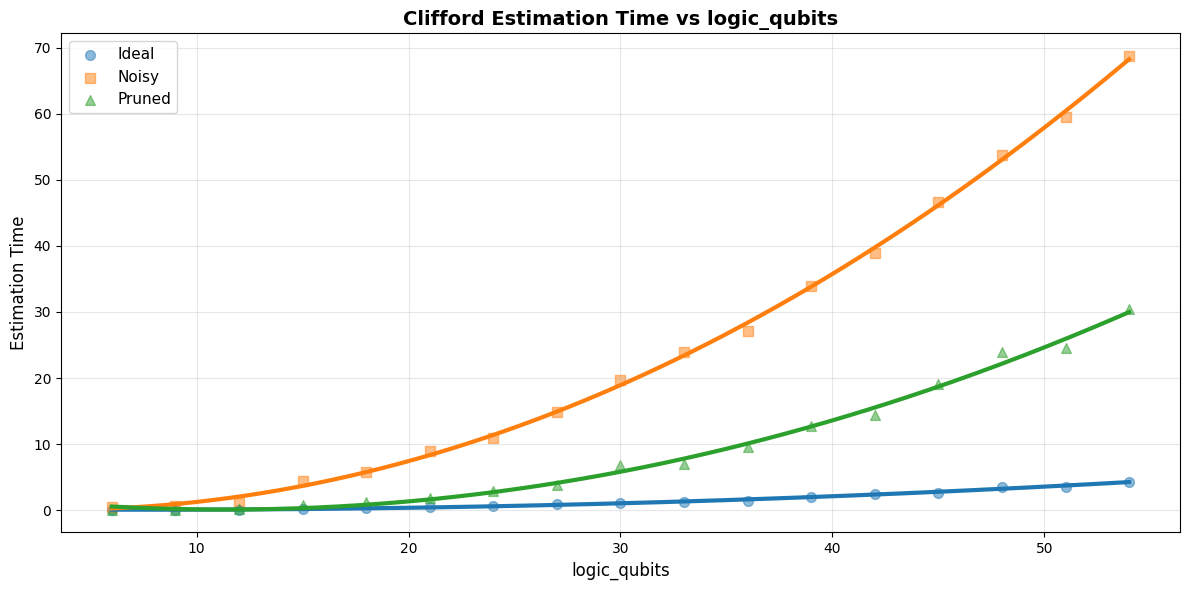

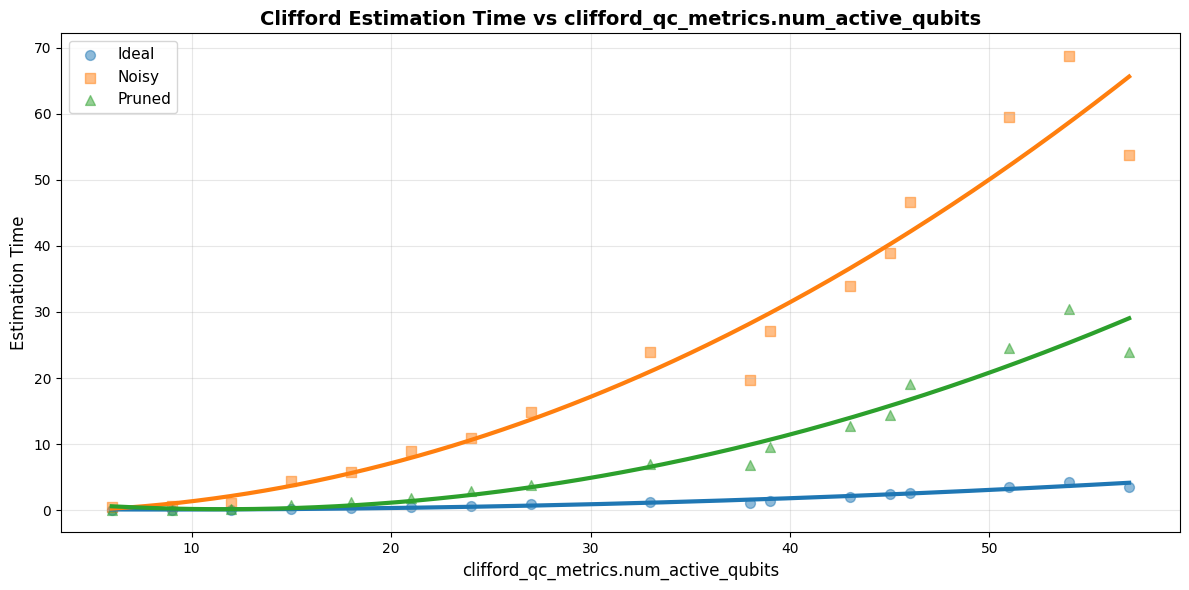

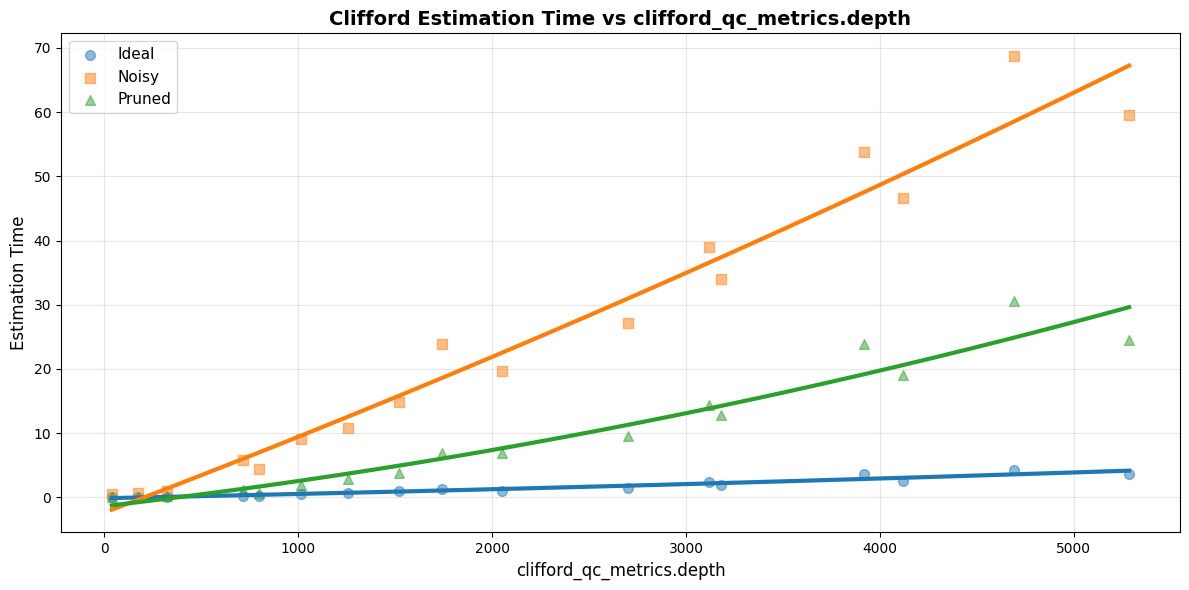

In [ ]:
# plot clifford estimation time with number of qubits and depth
mask = df.layers==1
plot_clifford_estimation_times_vs('logic_qubits', df[mask])
plot_clifford_estimation_times_vs('clifford_qc_metrics.num_active_qubits', df[mask])
plot_clifford_estimation_times_vs('clifford_qc_metrics.depth', df[mask])

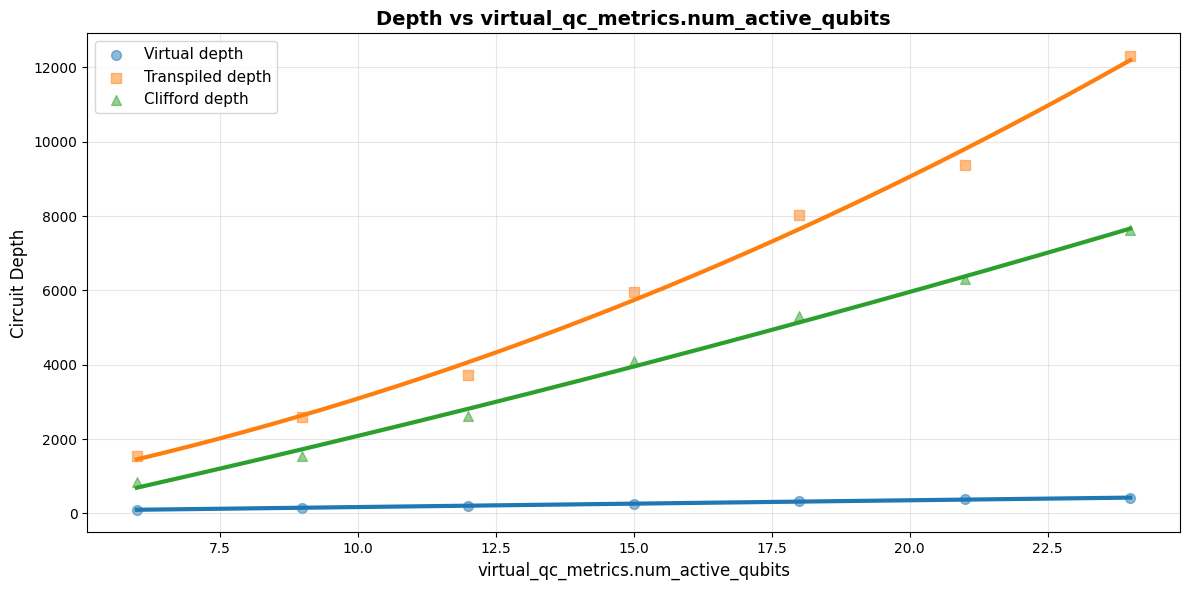

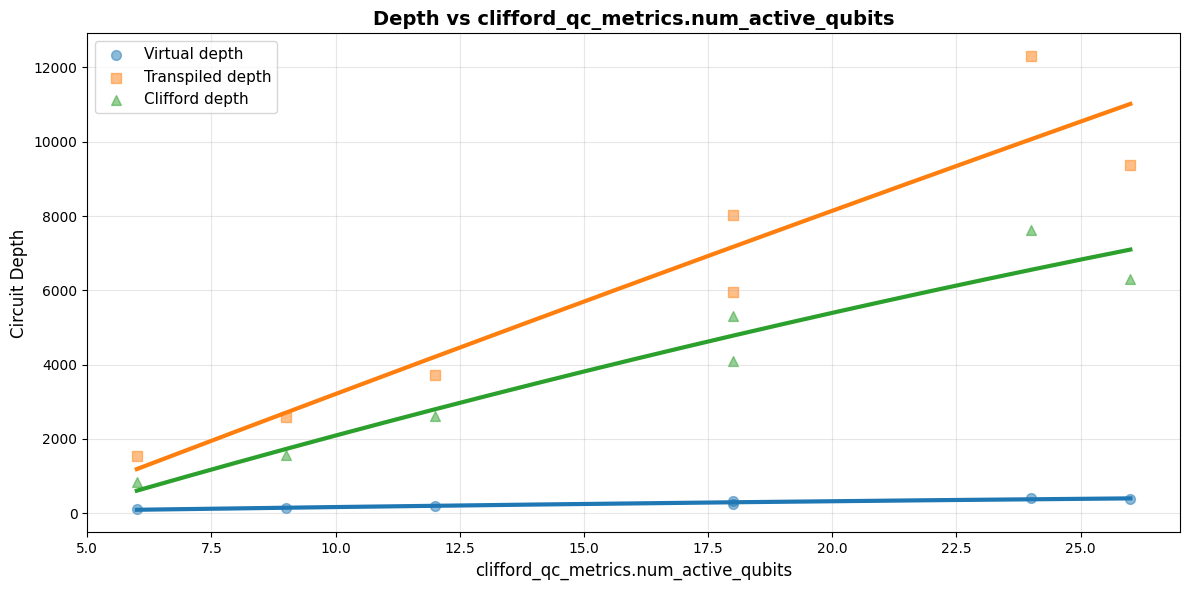

In [60]:
# Plot depths vs number of active qubits
mask = df.layers==5
plot_depths_vs('virtual_qc_metrics.num_active_qubits', df[mask])
plot_depths_vs('clifford_qc_metrics.num_active_qubits', df[mask])

In [ ]:
# Calculate energy difference and time advantage metrics
mask = df.index == df.index  # all rows
df_metrics = df[mask].copy()

# Energy difference: clifford_noisy_energy - clifford_pruned_energy
df_metrics['energy_diff'] = df_metrics['clifford_noisy_energy'] - df_metrics['clifford_pruned_energy']

# Time advantage percentage: (1 - pruned/noisy) * 100
df_metrics['time_advantage_pct'] = (1 - df_metrics['clifford_pruned_estimation_time'] / df_metrics['clifford_noisy_estimation_time']) * 100

# Plot 1: Energy difference vs clifford num_active_qubits
plot_metric_vs('clifford_qc_metrics.num_active_qubits', 'energy_diff', df_metrics, 
               'Energy Difference (Noisy - Pruned)', 'Energy Difference vs Clifford Active Qubits')

# Plot 2: Time advantage vs clifford num_active_qubits
plot_metric_vs('clifford_qc_metrics.num_active_qubits', 'time_advantage_pct', df_metrics,
               'Time Advantage (%)', 'Pruned vs Noisy Time Advantage vs Clifford Active Qubits')

## Optimization Analysis

Analysis of optimization experiments.